In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)



# Triage Accuracy

(How many patients did they over- or under-tag.)


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/error_table.png" />


## Create the error table

In [5]:

error_table_df = pd.DataFrame([
    {'DEAD': 'Exact', 'EXPECTANT': 'Critical', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Exact', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Exact', 'DELAYED': 'Over', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Exact', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Under', 'MINIMAL': 'Exact'}
], columns=['DEAD', 'EXPECTANT', 'IMMEDIATE', 'DELAYED', 'MINIMAL'], index=['black', 'gray', 'red', 'yellow', 'green'])

In [6]:

df = error_table_df.sample(4).dropna(axis='columns', how='all')
display(df.T)

,green,red,gray,black
DEAD,Over,Over,Over,Exact
EXPECTANT,Over,Over,Exact,Critical
IMMEDIATE,Under,Exact,Critical,Critical
DELAYED,Under,Over,Critical,Critical
MINIMAL,Exact,Over,Critical,Critical



## Create the error type data frame

In [4]:

if nu.pickle_exists('tag_to_salt_df'):
    tag_to_salt_df = nu.load_object('tag_to_salt_df')
    print(tag_to_salt_df.shape)
    df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(9874, 9)


,44,4351,6732,7233
logger_version,1.0,1.0,1.3,1.3
session_uuid,00b2e9d8-c3bb-4d89-92c1-abce5c4a0655,6f1a94ad-99cb-49a6-86f8-145e6c090fae,aec5d448-c4e6-4af7-8e36-d258c7bb6f96,bcfe163a-fb5b-43f8-8351-cb71adbfd6af
time_group,2,0,2,0
patient_id,Lily_4 Root,Mike_3 Root,Gary_1 Root,Gary_1 Root
patient_count,1,1,1,1
last_tag,red,NaN,gray,NaN
max_salt,IMMEDIATE,NaN,EXPECTANT,NaN
predicted_tag,red,NaN,gray,NaN
is_tag_correct,True,False,True,False


In [7]:

groupby_columns = ['last_tag', 'max_salt']
ERROR_TYPE_DF = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame()
def f(df):
    last_tag = df.name[0]
    # print(f'last_tag = {last_tag}')
    max_salt = df.name[1]
    # print(f'max_salt = {max_salt}')
    mask_series = (error_table_df.index == last_tag)
    error_type = error_table_df[mask_series][max_salt].squeeze()
    # print(f'error_type = {error_type}')
    
    return error_type
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF.apply(f, axis='columns')
ERROR_TYPE_DF = ERROR_TYPE_DF.reset_index()

In [48]:

print(ERROR_TYPE_DF.shape)
ERROR_TYPE_DF

(22, 4)


,last_tag,max_salt,patient_count,error_type
0,black,DEAD,372,Exact
1,black,EXPECTANT,68,Critical
2,black,IMMEDIATE,4,Critical
3,black,MINIMAL,2,Critical
4,gray,DEAD,9,Over
5,gray,DELAYED,4,Critical
6,gray,EXPECTANT,242,Exact
7,gray,IMMEDIATE,45,Critical
8,gray,MINIMAL,7,Critical
9,green,DELAYED,74,Under



## Display some violin plots

In [45]:

import seaborn as sns

def show_violin_plots(column_name, xlabel, title_suffix='Tags', palette=None):
    import seaborn as sns
    
    # Sample data for the violin plot
    data = {
        column_name: ERROR_TYPE_DF[column_name].tolist(),
        'patient_count': ERROR_TYPE_DF.patient_count.tolist()
    }
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    
    # Set the style of the plot
    sns.set(style='whitegrid')
    
    # Create the violin plot with 5 violins
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=column_name, y='patient_count', data=df, palette=palette, inner='stick')
    
    # Set plot labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Patient Count')
    plt.title(f'Distribution of Patient Count across different {title_suffix}')
    
    # Show the plot
    plt.show()

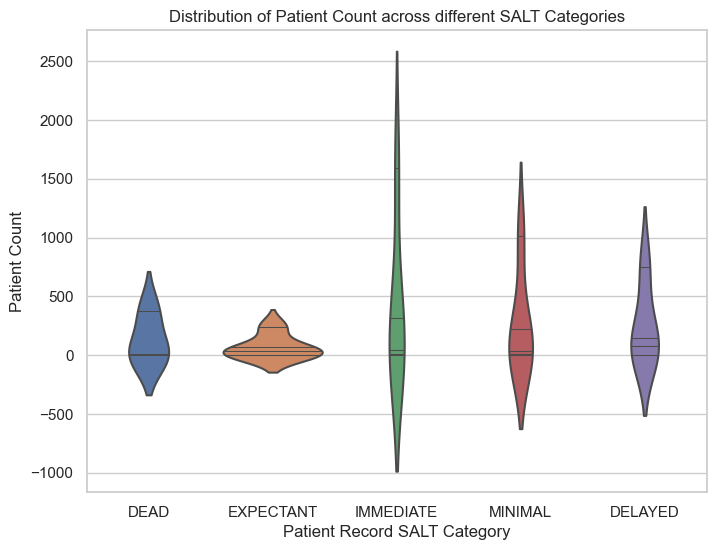

In [52]:

show_violin_plots('max_salt', 'Patient Record SALT Category', title_suffix='SALT Categories', palette=None)

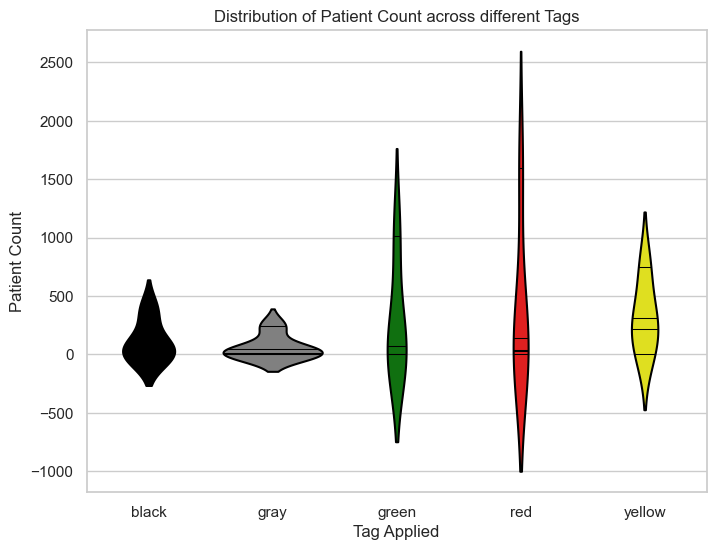

In [49]:

unique_tags = ERROR_TYPE_DF.last_tag.unique()
show_violin_plots('last_tag', 'Tag Applied', title_suffix='Tags', palette=unique_tags)

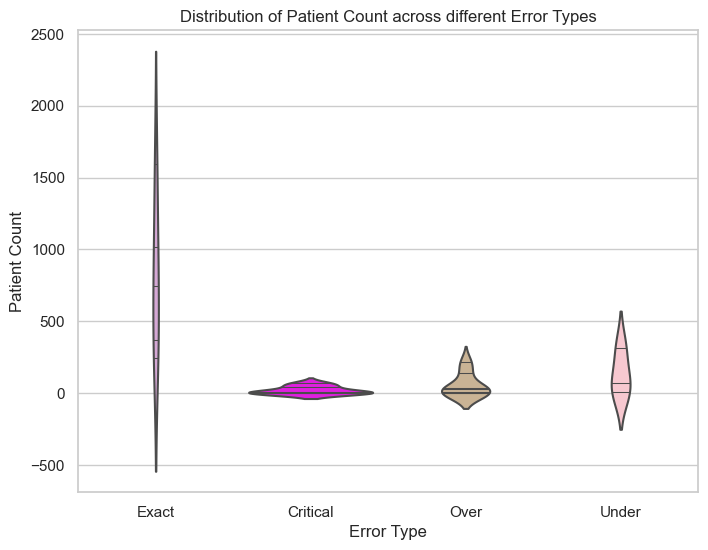

In [47]:

colors_list = ['plum', 'fuchsia', 'tan', 'pink']
show_violin_plots('error_type', 'Error Type', title_suffix='Error Types', palette=colors_list)


## Display some pie charts

In [10]:

import matplotlib.colors as mcolors
import random
import numpy as np

error_colors = ['black', 'gray', 'red', 'yellow', 'green']
color_substrings = error_colors + ['grey']
error_values = ['Critical', 'Exact', 'Over', 'Under']
# colors_list = random.sample(
#     [color_name for color_name in mcolors.CSS4_COLORS.keys() if not any(map(lambda x: (x in color_name), color_substrings))],
#     len(error_values)
# )
colors_list = ['fuchsia', 'plum', 'tan', 'pink']
LABELS_DICT = {k: v for k, v in zip(error_values, colors_list)}
suffixed_fn = lambda x: f'{x}-tagged' if (x in ['Over', 'Under']) else x
idx = color_substrings.index('gray'); color_substrings.pop(idx); color_substrings.pop(color_substrings.index('grey')); color_substrings.insert(idx, 'gray/grey')
print(f"The colors are a random assortment of CSS4 colors whose names don't have the tag colors ({nu.conjunctify_nouns(color_substrings)}) as substrings in them. I haven't nailed them down yet. These particular colors are {nu.conjunctify_nouns([f'{v} for {suffixed_fn(k)}' for k, v in LABELS_DICT.items()])}.")

The colors are a random assortment of CSS4 colors whose names don't have the tag colors (black, gray/grey, red, yellow, and green) as substrings in them. I haven't nailed them down yet. These particular colors are fuchsia for Critical, plum for Exact, tan for Over-tagged, and pink for Under-tagged.



### Total pie chart

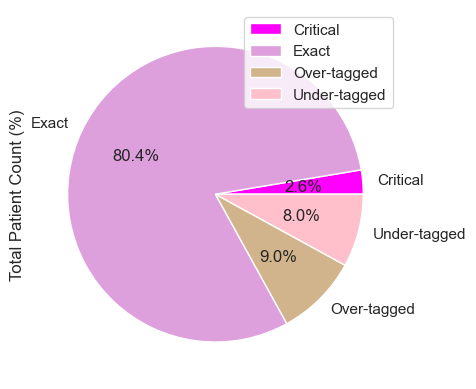

In [44]:

df = ERROR_TYPE_DF.groupby('error_type').sum().reset_index()
df.error_type = df.error_type
# display(nu.get_statistics(['patient_count'], df).applymap(lambda x: round(x, 1), na_action='ignore').T)
df.plot.pie(
    autopct='%1.1f%%', y='patient_count', ylabel='Total Patient Count (%)', labels=df.error_type.map(suffixed_fn),
    colors=[LABELS_DICT[k] for k in df.error_type]
);

In [41]:

def show_pie_charts(column_name, title_prefix='', suptitle=None):
    
    # Calculate the number of plots and the number of rows and columns
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    num_plots = len(unique_categories)
    num_rows = min(num_plots, 2)
    num_cols = int(np.ceil(num_plots / num_rows))
    
    # # Create a figure and subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=False)
    
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').sum().reset_index()
        # display(nu.get_statistics(['patient_count'], df).applymap(lambda x: round(x, 1), na_action='ignore').rename(
        #     columns={'patient_count': f'{column_value.lower()}_patient_count'}
        # ).T)
        df.plot.pie(
            autopct='%1.1f%%', y='patient_count', ylabel='', labels=df.error_type.map(suffixed_fn),
            colors=[LABELS_DICT[k] for k in df.error_type], ax=axs[i // num_cols, i % num_cols], title=f'{title_prefix}{column_value.title()}'
        );
    
    # Remove the remainder of the plots
    i += 1
    while i < (num_rows * num_cols):
        axs[i // num_cols, i % num_cols].remove()
        i += 1

    if suptitle is not None: fig.suptitle(suptitle)


#### Pie charts grouped by last tag

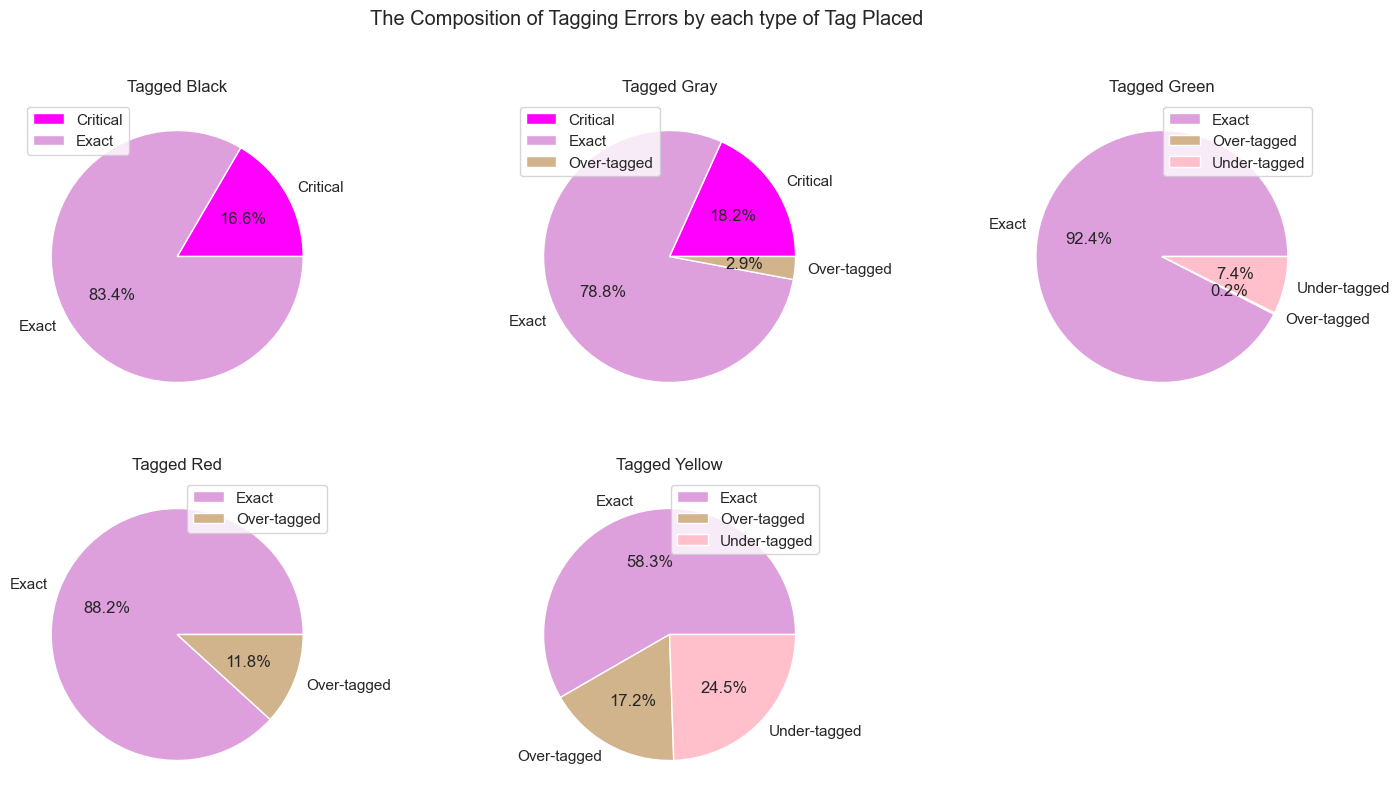

In [42]:

show_pie_charts('last_tag', title_prefix='Tagged ', suptitle='The Composition of Tagging Errors by each type of Tag Placed')


#### Pie charts grouped by max salt

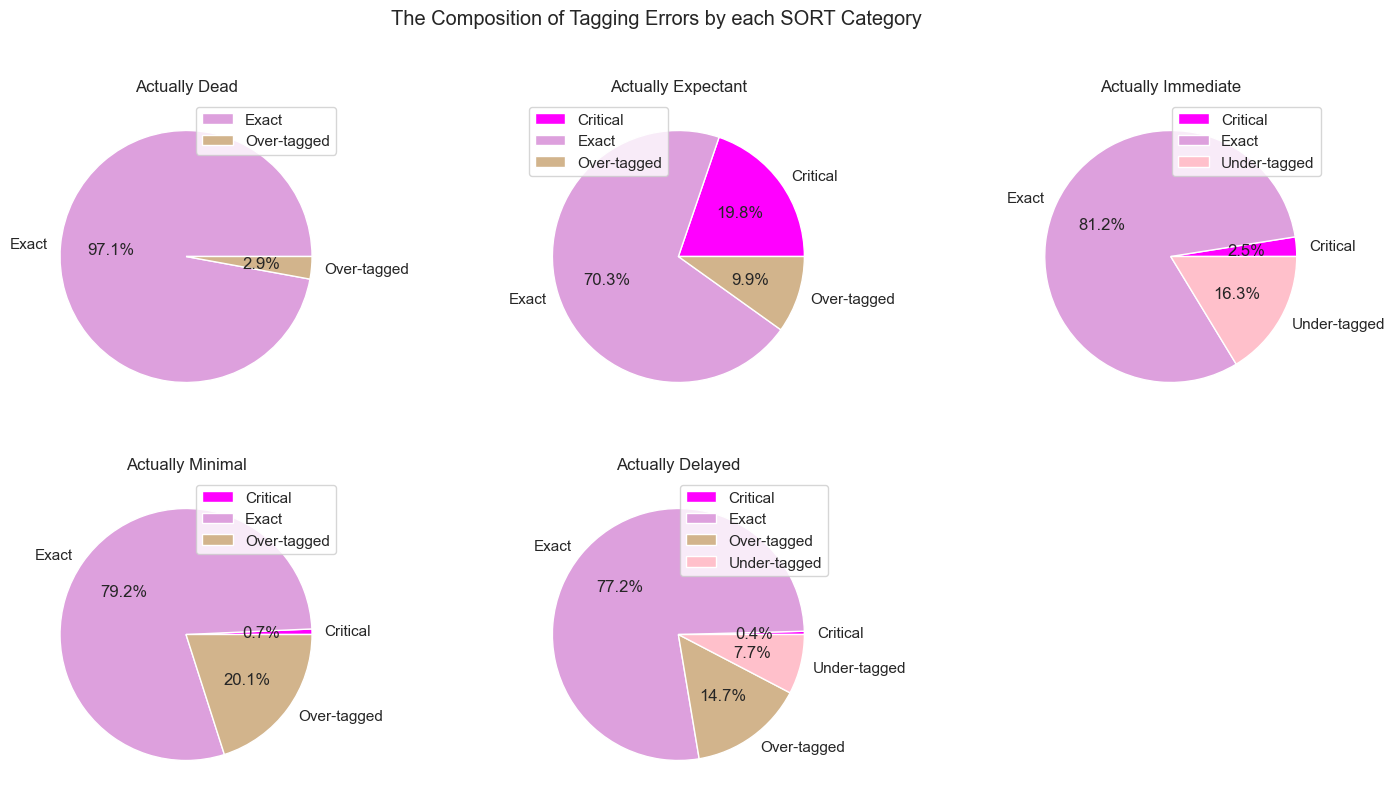

In [43]:

show_pie_charts('max_salt', title_prefix='Actually ', suptitle='The Composition of Tagging Errors by each SORT Category')

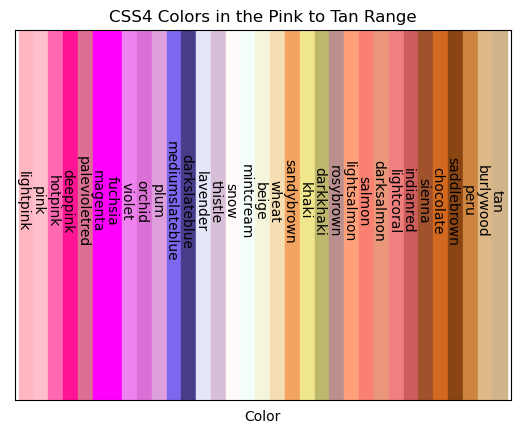

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a list of the CSS4 colors in the pink to tan range
colors = [
    'lightpink', 'pink', 'hotpink', 'deeppink', 'palevioletred', 'magenta',
    'fuchsia', 'violet', 'orchid', 'plum', 'mediumslateblue', 'darkslateblue',
    'lavender', 'thistle', 'snow', 'mintcream', 'beige', 'wheat', 'sandybrown',
    'khaki', 'darkkhaki', 'rosybrown', 'lightsalmon', 'salmon', 'darksalmon',
    'lightcoral', 'indianred', 'sienna', 'chocolate', 'saddlebrown', 'peru',
    'burlywood', 'tan'
]

# Create a figure and axes
fig, ax = plt.subplots()

# Create a rectangle for each color
for i in range(len(colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))

# Set the x and y limits
ax.set_xlim(-0.25, len(colors) + 0.25)
ax.set_ylim(0, 1)

# Set the x and y labels
ax.set_xlabel('Color')

# Turn off the axes
ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_yticks([])

# Set the title
ax.set_title('CSS4 Colors in the Pink to Tan Range')

# Annotate each color
for i in range(len(colors)):
    ax.annotate(
        colors[i],
        xy=(i + 1.25, 0.5),
        xytext=(-10, 10),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        va='center',
        rotation=-90
    )

# Show the plot
plt.show()
